<a href="https://colab.research.google.com/github/othniel77/datascience/blob/main/Projet_Waze_chez_Cr%C3%A9dit_Agricole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet Waze Crédit Agricole

In [1]:
# importer les packages pour la manipulation des données
import numpy as np
import pandas as pd

# Importer pour la visualisations des données
import matplotlib.pyplot as plt

# Cela nous permet de voir toutes les colonnes empechant jupyter de les rédiger
pd.set_option('display.max_columns', None)

# Importer des packages pour la modélisation des données
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# C'est la fonction qui permet de tracer l'importance des foctionnalités
from xgboost import plot_importance

# Ce modèle nous permet de sauvegarder nos modèles une fois que nous les avons ajustés
import pickle

In [2]:
! pip install xgboost

In [3]:
from xgboost import XGBClassifier

# C'est la fonction qui permet de tracer l'importance des foctionnalités
from xgboost import plot_importance

# Ce modèle nous permet de sauvegarder nos modèles une fois que nous les avons ajustés
import pickle

In [4]:
from google.colab import files
data_to_load = files.upload()

Saving waze_dataset.csv to waze_dataset.csv


In [56]:
df0 = pd.read_csv('/content/waze_dataset.csv')
df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [57]:
# Copiez la trame de données
df = df0.copy()

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


In [59]:
# Créer la fonctionnalité 'km_per-driving_day'
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# Obtenez des statistiques descriptives
df['km_per_driving_day'].describe()


count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

In [60]:
# 1. Convertir  des valeurs infinis en zéro
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# Confirmer que cela a fonctionné
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

In [61]:
# 1. Créer la fonctionnalité percent_sessions_in_last_month
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

# 2. Obtenez des statistiques descriptives
df['percent_sessions_in_last_month'].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

In [62]:
# Créer la fonctionnalité 'professional_driver'
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] > 15),1,0)

In [63]:
# Créer la fonctionnalité 'total_sessions_per_day'
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

In [64]:
# Obtenez des statistiques descriptives
df['total_sessions_per_day'].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sessions_per_day, dtype: float64

In [65]:
# Créer ue fonctionnalité 'km_per_hour'
df['km_per_hour'] = df['driven_km_drives'] / df['duration_minutes_drives'] / 60
df['km_per_hour'].describe()

count    14999.000000
mean         0.052887
std          0.092965
min          0.020004
25%          0.025196
50%          0.033995
75%          0.053647
max          6.567478
Name: km_per_hour, dtype: float64

In [66]:
# Créer la fonctionnalité 'km_per_drive'
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df['km_per_drive'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

In [67]:
# 1. Convertir des valeurs infinies en zéro
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0

# 2. Confirmez que cela a fonctionné
df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

In [68]:
# Créer la fonctionnalité 'percent_of_sessions_to_favorite'
df['percent_of_drives_to_favorite'] = (
 df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

# Obtenez des statistiques descriptives
df['percent_of_drives_to_favorite'].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percent_of_drives_to_favorite, dtype: float64

In [69]:
# supprimer les lignes avec les valeurs manquantes
df = df.dropna(subset=['label'])

In [70]:
# Créer une nouvelle variable 'device2'
df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


In [71]:
# Créons une colonne binaire 'label2'
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


In [72]:
# Supprimer la colonne ID
df = df.drop(['ID'], axis=1)

In [73]:
# Obtenez le solde des classes du colonne 'label'
df['label'].value_counts(normalize=True)

retained    0.822645
churned     0.177355
Name: label, dtype: float64

In [74]:
# Isoler les variables X
X = df.drop(columns=['label', 'label2', 'device'])

# Isoler la variable Y
y = df['label2']

# Diviser en ensemble de train et de test
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y,
 test_size=0.2, random_state=42)

# Diviser en ensemble de train et de validation
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr,
 test_size=0.25, random_state=42)

In [75]:
for x in [X_train, X_val, X_test]:
 print(len(x))

8579
2860
2860


In [76]:
# Instanciez le classificateur de foret aléatoire
rf = RandomForestClassifier(random_state=42)

#Créer un dictionnaire d'hperparamètre à régler
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300],
            }

# Définir un dictionnairede métriques de scoring à capturer
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instanciez l'objet GridSearchCV
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

In [77]:
%%time

rf_cv.fit(X_train, y_train)

CPU times: user 2min 31s, sys: 179 ms, total: 2min 32s
Wall time: 2min 32s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall', scoring={'accuracy', 'recall', 'f1', 'precision'})

In [78]:
# Examiner le meilleur
rf_cv.best_score_

0.12678201409034398

In [79]:
# Examiner la meilleure combinaison
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [80]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output t
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''
    # Créer un dictionnaire qui mappe la métrique d'entrée au nom réel de la métrique dans GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                    'recall': 'mean_test_recall',
                    'f1': 'mean_test_f1',
                    'accuracy': 'mean_test_accuracy',
                     }
    # Récupérer tous les résultats du CV et meetez-les dans un df
    cv_results = pd.DataFrame(model_object.cv_results_)
    # Isoler la ligne du df avec le score max(métrique)
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extraire l'exactitude, la précision, le rappel et le score F1 de cette ligne
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Créer un tableau des résultats
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [81]:
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.45726,0.126782,0.198447,0.81851


In [82]:
# 1. Instanciez le classificateur XGBoost
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. créer un dictionnaire d'hyperparamètre à régler
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
            }

# 3. Définir un dictionnaire de métriques de scoring à capturer
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instanciez l'objet  GridSearchCV
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

In [83]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 2min 5s, sys: 574 ms, total: 2min 5s
Wall time: 1min 11s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall', scoring={'accuracy', 'recall', 'f1', 'precision'})

In [85]:
# Examiner le meilleur
xgb_cv.best_score_

0.18003349910208594

In [86]:
# Examiner les meilleurs paramètres
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 300}

In [87]:
# Appelez make_results() sur l'objet GridSearch
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457260,0.126782,0.198447,0.818510
0,XGB cv,0.442149,0.180033,0.255812,0.814198


In [88]:
# Utiliser le modèle de foret aléatoire pour prédire les données de validation
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

In [89]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.
    In:
        model_name (string): Your choice: how the model will be named in the outp
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data
    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                         })
    return table

In [90]:
# Obtenez les scores de validation pour le modèle de foret aléatoire
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

# Ajouter au tableau des résultats
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457260,0.126782,0.198447,0.818510
0,XGB cv,0.442149,0.180033,0.255812,0.814198
0,RF val,0.434783,0.118343,0.186047,0.816434


In [91]:
# Utilisons le modèle XGBoost pour prédire les données de validation
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Obtenez les scores de validation pour le modèle XGBoost
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

# Ajouter au tableau des résultats
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457260,0.126782,0.198447,0.818510
0,XGB cv,0.442149,0.180033,0.255812,0.814198
0,RF val,0.434783,0.118343,0.186047,0.816434
0,XGB val,0.392670,0.147929,0.214900,0.808392


In [92]:
# Utiliser le modèle XGBoost pour prédire les données de test
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Obtenez les résultats des test pour le modèle XGBoost
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)
# Ajouter au tableau des résultats
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457260,0.126782,0.198447,0.818510
0,XGB cv,0.442149,0.180033,0.255812,0.814198
0,RF val,0.434783,0.118343,0.186047,0.816434
0,XGB val,0.392670,0.147929,0.214900,0.808392
0,XGB test,0.421569,0.169625,0.241913,0.811538


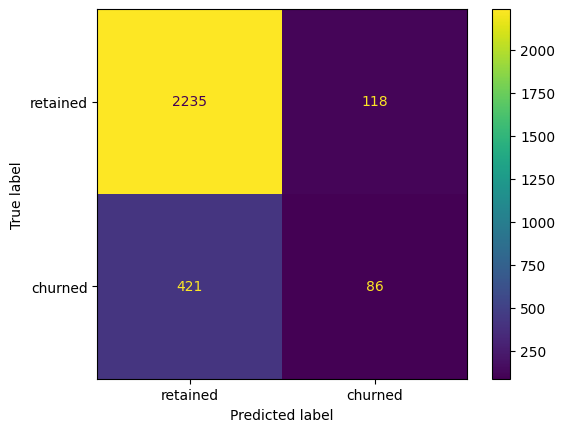

In [93]:
# Générer un tableau de valeur pour la matrice de confusion
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)
# Tracer la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
 display_labels=['retained', 'churned'])
disp.plot();

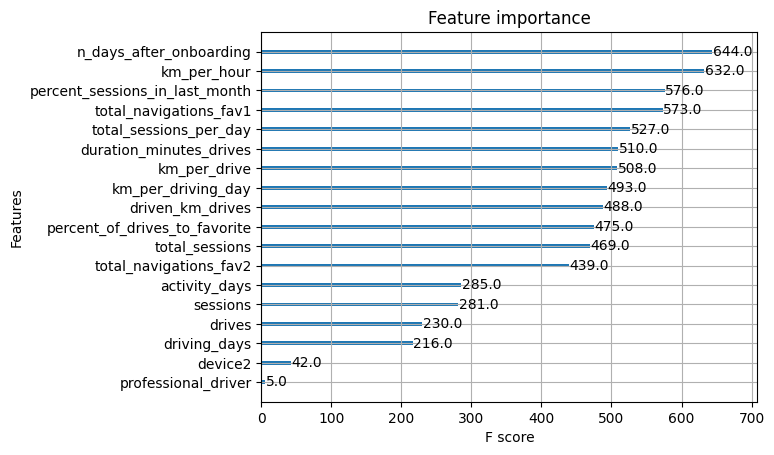

In [94]:
plot_importance(xgb_cv.best_estimator_);

In [95]:
from sklearn.metrics import PrecisionRecallDisplay

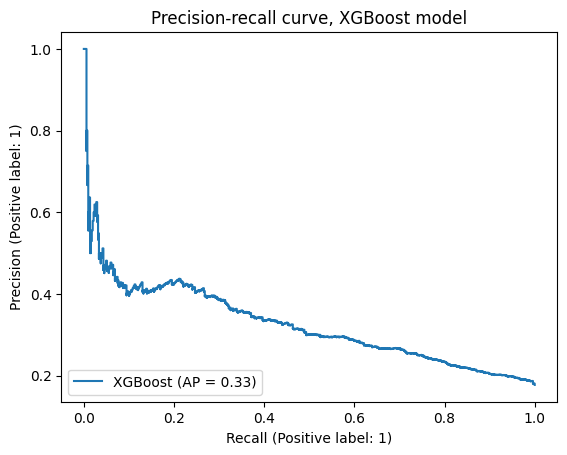

In [96]:
# Plot precision-recall curve
display = PrecisionRecallDisplay.from_estimator(
    xgb_cv.best_estimator_, X_test, y_test, name='XGBoost'
    )
plt.title('Precision-recall curve, XGBoost model');

In [97]:
# Obtenez les probabilités prédites sur les données test
predicted_probabilities = xgb_cv.best_estimator_.predict_proba(X_test)
predicted_probabilities

array([[0.9262936 , 0.07370641],
       [0.5827221 , 0.41727787],
       [0.9781319 , 0.02186812],
       ...,
       [0.80336773, 0.19663225],
       [0.941996  , 0.05800399],
       [0.6979869 , 0.3020131 ]], dtype=float32)

In [98]:
# Créer une liste des valeurs de la deuxième colonne uniquement(probabilité de cible)
probs = [x[1] for x in predicted_probabilities]
# Créer un tableau de nouvelles prédictions qui attribue un 1 à toute valeur >=0.4
new_preds = np.array([1 if x >= 0.4 else 0 for x in probs])
new_preds

array([0, 1, 0, ..., 0, 0, 0])

In [99]:
# Obtenez  des métriques d'évaluation lorsque le seuil est de 0.4
get_test_scores('XGB, threshold = 0.4', new_preds, y_test)

,model,precision,recall,F1,accuracy
0,"XGB, threshold = 0.4",0.403561,0.268245,0.322275,0.8


In [100]:
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457260,0.126782,0.198447,0.818510
0,XGB cv,0.442149,0.180033,0.255812,0.814198
0,RF val,0.434783,0.118343,0.186047,0.816434
0,XGB val,0.392670,0.147929,0.214900,0.808392
0,XGB test,0.421569,0.169625,0.241913,0.811538


In [101]:
def threshold_finder(y_test_data, probabilities, desired_recall):
    '''
     Find the decision threshold that most closely yields a desired recall score.
     Inputs:
             y_test_data: Array of true y values
             probabilities: The results of the `predict_proba()` model method
             desired_recall: The recall that you want the model to have
     Outputs:
             threshold: The decision threshold that most closely yields the desired re
             recall: The exact recall score associated with `threshold`
     '''
    probs = [x[1] for x in probabilities] # Isolate second column of `probabilit
    thresholds = np.arange(0, 1, 0.001) # Set a grid of 1,000 thresholds to te
    scores = []
    for threshold in thresholds:
     # Create a new array of {0, 1} predictions based on new threshold
        preds = np.array([1 if x >= threshold else 0 for x in probs])
     # Calculate recall score for that threshold
        recall = recall_score(y_test_data, preds)
     # Append the threshold and its corresponding recall score as a tuple to `
    scores.append((threshold, recall))
    distances = []
    for idx, score in enumerate(scores):
    # Calculate how close each actual score is to the desired score
        distance = abs(score[1] - desired_recall)
    # Append the (index#, distance) tuple to `distances`
        distances.append((idx, distance))
     # Sort `distances` by the second value in each of its tuples (least to greate
    sorted_distances = sorted(distances, key=lambda x: x[1], reverse=False)
     # Identify the tuple with the actual recall closest to desired recall
    best = sorted_distances[0]
    # Isolate the index of the threshold with the closest recall score
    best_idx = best[0]
     # Retrieve the threshold and actual recall score closest to desired recall
    threshold, recall = scores[best_idx]
    return threshold, recall

In [102]:
# Obtenez les probabilités prédites du modèle champion
probabilities = xgb_cv.best_estimator_.predict_proba(X_test)

# Appeler la fonction
threshold_finder(y_test, probabilities, 0.5)

(0.999, 0.0)

In [103]:
# Créer un tableau de nouvelles prédictions qui attribue un 1 à n'importe quelle valeur >= 0.124
new_preds = np.array([1 if x >= 0.124 else 0 for x in probs])
# Obtenez des métriques d'évaluation lorsque le seuil est de 0.124
get_test_scores('XGB, threshold = 0.124', new_preds, y_test)

,model,precision,recall,F1,accuracy
0,"XGB, threshold = 0.124",0.270404,0.646943,0.381395,0.627972
